<font size=6>Liquidity & Finaicial Conditions v. Bitcoin price</font><br>
ECN, FED, BTC: data source: https://www.federalreserve.gov/
Bitcoin, Dogecoin, Cardano, Etehreum: coingecko

In [2]:
import pandas as pd
# import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime
from pycoingecko import CoinGeckoAPI  # Community project. See: https://github.com/man-c/pycoingecko

import ipywidgets as widgets
from ipywidgets import HBox, Layout
import sys
sys.path.append('/home/lstm/Github/jp-codes-ubuntu/modules/')
if os.environ['NAME'] == 'DESKTOP-OCNB1KD': 
    sys.path.append('/mnt/c/users/jp/Documents/Github/jp-codes-ubuntu/modules/')
import dummyf

# define data folder fo downloaded data
data_root = '/home/lstm/insync/jaesangpark@gmail.com/Google Drive/'
if os.environ['NAME'] == 'DESKTOP-OCNB1KD': data_root = '/mnt/g/내 드라이브/'

# collect data (CSV)
# BS_ECB = pd.read_csv(data_root + 'Data Exchange/ESG/data/ECBASSETSW.csv', index_col='DATE', parse_dates=True)
BS_FED = pd.read_csv(data_root + 'Data Exchange/ESG/data/WALCL.csv', index_col='DATE', parse_dates=True)
FCI = pd.read_csv(data_root + 'Data Exchange/ESG/data/NFCI.csv', index_col='DATE', parse_dates=True)
# BTC = pd.read_csv(data_root + 'Data Exchange/ESG/data/CBBTCUSD.csv', index_col='DATE', parse_dates=True)#.set_index('DATE')
list_fut = ['@NQ#C_D', '@ES#C_D']
names_dict = {'@NQ#C_D': 'NASDAQ', '@ES#C_D':'SP500'}
df_fut = pd.DataFrame()
for fut in list_fut:
    dd = pd.read_csv(data_root + 'Data Exchange/ESG/data/' + fut + '.csv', index_col='Date', parse_dates=True)[['Close']]
    dd.columns = [names_dict[fut]]
    df_fut = pd.concat([df_fut, dd], axis=1)

# collect crypto data (coingecko)
cg = CoinGeckoAPI()
df_gecko = pd.DataFrame(cg.get_coins_list())
num_days = 2000

list_crypto = ['bitcoin', 'ethereum', 'cardano', 'dogecoin']
colnames = {'bitcoin':'BTC', 'ethereum':'ETH', 'cardano':'ADA', 'dogecoin':'DOGE'}
df_price = pd.DataFrame()
for sym in list_crypto:      
    gecko_data = cg.get_coin_market_chart_by_id(sym, vs_currency='USD', days=num_days)    

    df_pr = pd.DataFrame(gecko_data['prices'])
    df_pr.columns = ['date', sym]
    df_pr['date'] = df_pr['date'].div(1000).apply(datetime.fromtimestamp)
    df_pr.set_index('date', inplace=True)
    df_pr.index = pd.DatetimeIndex(df_pr.index.date)
    df_pr = df_pr.loc[~df_pr.index.duplicated(keep='last'), :]    
    df_price = pd.concat([df_price, df_pr], axis=1, join='outer')

df_price = df_price.sort_index().rename(columns=colnames).dropna()
df_price.index.name = 'date'

# add week number column
# BS_ECB['week'] = pd.to_datetime(BS_ECB.index).strftime('%Y-%U')
BS_FED['week'] = pd.to_datetime(BS_FED.index).strftime('%Y-%U')
FCI['week'] = pd.to_datetime(FCI.index).strftime('%Y-%U')
df_price['week'] = pd.to_datetime(df_price.index).strftime('%Y-%U')
df_fut['week'] = pd.to_datetime(df_fut.index).strftime('%Y-%U')

# add common datetime column (monday of each week)
# BS_ECB['anchor_date'] = BS_ECB.index + pd.offsets.Week(weekday=0)
BS_FED['anchor_date'] = BS_FED.index + pd.offsets.Week(weekday=0)
FCI['anchor_date'] = FCI.index + pd.offsets.Week(weekday=0)
df_price['anchor_date'] = df_price.index + pd.offsets.Week(weekday=0)
df_fut['anchor_date'] = df_fut.index + pd.offsets.Week(weekday=0)

# set anchor date as index
# BS_ECB = BS_ECB.set_index('anchor_date').drop(columns=['week'])
BS_FED = BS_FED.set_index('anchor_date').drop(columns=['week'])
FCI = FCI.set_index('anchor_date').drop(columns=['week'])
df_price = df_price.set_index('anchor_date').drop(columns=['week'])
df_fute = df_fut.set_index('anchor_date').drop(columns=['week'])

# drop duplicates
# BS_ECB = BS_ECB.loc[~BS_ECB.index.duplicated(keep='last'), :]
BS_FED = BS_FED.loc[~BS_FED.index.duplicated(keep='last'), :]
FCI = FCI.loc[~FCI.index.duplicated(keep='last'), :]
df_price = df_price.loc[~df_price.index.duplicated(keep='last'), :]
df_fut = df_fut.loc[~df_fut.index.duplicated(keep='last'), :]

# combine & clean up
# df = pd.concat([BS_ECB, BS_FED, NFCI, BTC], axis=1, join='inner') # exclude ECB (something funny there)
df = pd.concat([BS_FED, FCI, df_price, df_fut], axis=1, join='inner')
df = df.apply(pd.to_numeric, errors='coerce')

# flip NFCI to compare w/ rest
df['NFCI'] = df['NFCI'] * -1

# combine ECB & Fed BS
# df['BS'] = df['ECBASSETSW'] + df['WALCL']

In [3]:
# convert to index (NFCI is aleady indexized; just flop it to compare w/ the rest)
df_index = pd.concat([
    df.div(abs(df.iloc[0])).mul(100).loc[:, ['WALCL', 'BTC', 'ETH', 'ADA', 'DOGE', 'SP500', 'NASDAQ']],
    df.loc[:, ['NFCI']] * 100
])

In [4]:
# pick series to plot
names = df_index.columns
w_name = widgets.interactive(dummyf.dummyf, x=widgets.SelectMultiple(options=sorted(names), layout=Layout(width='400px', height='150px')))

HBox([widgets.Label('data series'), w_name])

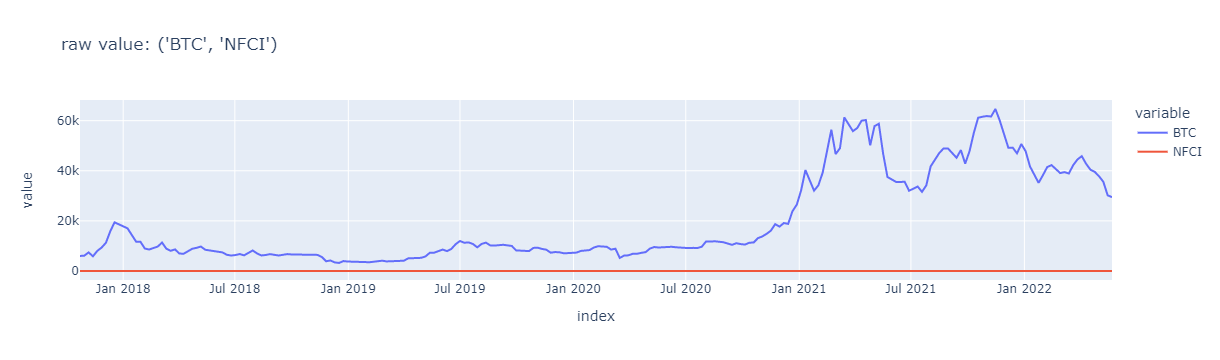

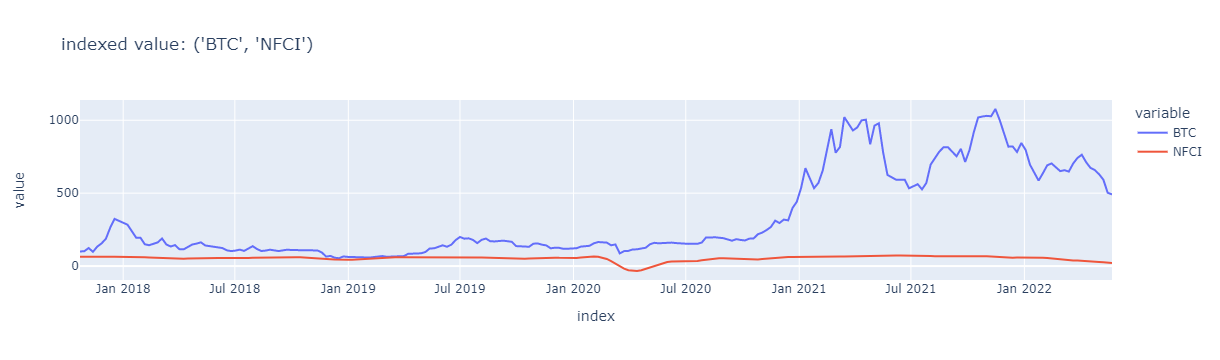

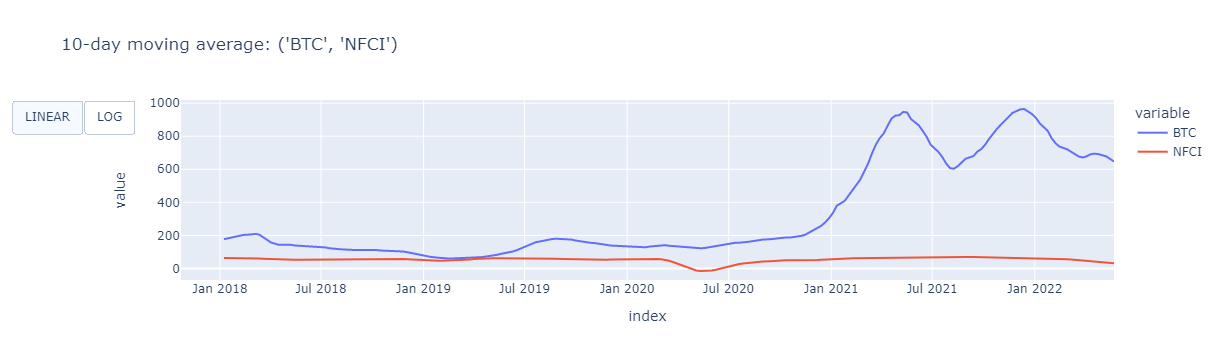

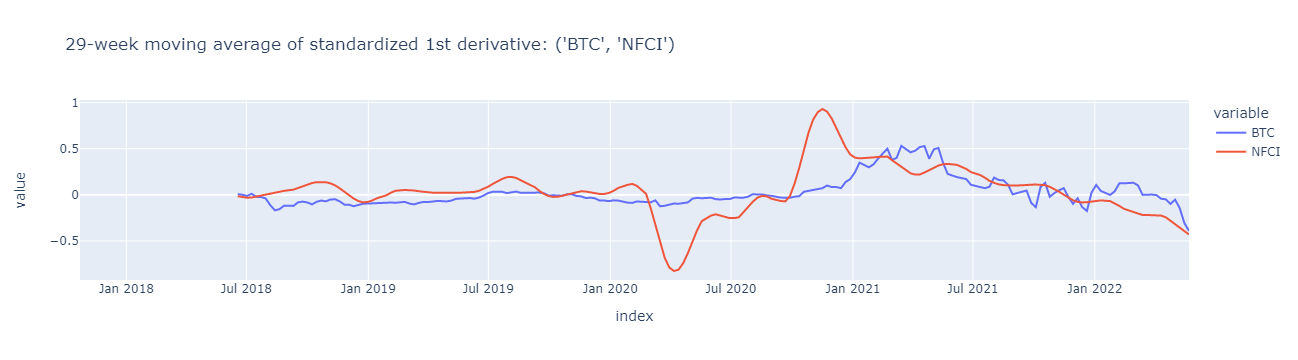

In [8]:
# plot
series_names = w_name.kwargs['x']
df_select_raw = df.loc[:, series_names]
df_select = df_index.loc[:, series_names]

pd.options.plotting.backend = "plotly" #"matplotlib"

# raw value
fig0 = df_select_raw.plot(title='raw value: ' + str(series_names))
fig0.show()

# index
fig0 = df_select.plot(title='indexed value: ' + str(series_names))
fig0.show()

# # PCT change
# fig1 = df_select.pct_change().cumsum().plot(title='PCT change: ' + str(series_names))
# fig1.show()

# rolling mean
span = 10
fig2 = df_select.rolling(span).mean().plot(title=str(span)+'-day moving average: ' + str(series_names))

fig2.update_layout(
    hovermode='x unified',
    updatemenus=[
        dict(
            type = "buttons",
            direction = "left",
            buttons=list([
                dict(
                    args=[{"yaxis.type": "linear"}],
                    label="LINEAR",
                    method="relayout"
                ),
                dict(
                    args=[{"yaxis.type": "log"}],
                    label="LOG",
                    method="relayout"
                )
            ]),
        ),
    ]
)
fig2.show()

# Logarithm
# fig3 = np.log10(df_select).plot(title='log10: ' + str(series_names))
# fig3.show()

# # log rolling mean
# fig4 = np.log10(df_select).rolling(span).mean().plot(title=str(span)+'-day moving average (log10): ' + str(series_names))
# fig4.show()

# # rolling correaltion (10 weeks, BS - BTC)
# fig5 = df_select['WALCL'].rolling(span).corr(df_index['BTC']).plot(title=str(span)+'-week moving correlation, WALCL-BTC')
# fig5.show()

# # rolling correaltion (10 weeks, NFCI - BTC)
# fig6 = df_select['NFCI'].rolling(span).corr(df_select['BTC']).plot(title=str(span)+'-week moving correlation, NFCI-BTC')
# fig6.show()           

# # 1st derivative
df_diff = df_select.diff().div(df_select.index.to_series().diff().dt.days, axis=0)
# fig7 = df_diff.plot(title='1st derivative: ' + str(series_names))
# fig7.show()

# # standardized 1st derivative
df_diff_std = (df_diff - df_diff.mean())/df_diff.std()
# fig8 = df_diff_std.plot(title='standardized 1st derivative: ' + str(series_names))
# fig8.show()

# rolling averge of standardize 1st derivative()
span = 29
df_diff_std_roling = df_diff_std.rolling(span).mean()
fig9 = df_diff_std_roling.plot(title=str(span)+'-week moving average of standardized 1st derivative: ' + str(series_names))
fig9.show()

In [20]:
# correlation
df_index['WALCL'].corr(df_index['BTC'])

0.8268922333732356